## Clustering

Unsupervised learning is very useful in the domain of customer segmentation and understanding, among others. Often we have data about customers’ behavior, purchasing habits and website visits and we want to draw insights from the data, so that we can optimize our marketing strategies and ultimately, increase conversion.

In this assignment, we are asked to work with the ‘Mall customer segmentation data’ from Kaggle:

https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

Tasks and questions:

1) Perform clustering of the data (K-means or hierarchical clustering; or if you prefer - both). How many clusters are there in the data and why?  
2) How will your translate the clusters into business insight? In other words, what advice would you give the mall owner, so that they can design a marketing strategy using your insights.

In [1]:
#import required packages
import pandas as pd
from scipy.cluster.vq import whiten
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
#Import data

data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
#Check for missing values
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
#EDA
print(data.describe())
print(data.info())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtyp

There are 5 columns and 200 rows, with no missing values and none of the value ranges look incorrect.

Next let's convert the column names to lower case, handle the categorical column (`Gender`) by converting to dummy variables, and then use StandardScaler to standardise each of the columns.

In [5]:
data.columns = data.columns.str.lower()
data_dummies = pd.get_dummies(data, drop_first=True)

#Scale data
data_scaled = whiten(data_dummies)

#Convert back to Dataframe
data_scaled = pd.DataFrame(data_scaled, columns=data_dummies.columns)

#Check
print(data_scaled.head())

   customerid       age  annual income (k$)  spending score (1-100)  \
0    0.017321  1.363567            0.572541                1.514041   
1    0.034641  1.507100            0.572541                3.144546   
2    0.051962  1.435334            0.610711                0.232929   
3    0.069283  1.650634            0.610711                2.989260   
4    0.086604  2.224767            0.648880                1.552862   

   gender_Male  
0     2.014557  
1     2.014557  
2     0.000000  
3     0.000000  
4     0.000000  


Next let's use an elbow plot to see if the clusters can be easily identified using kmeans.

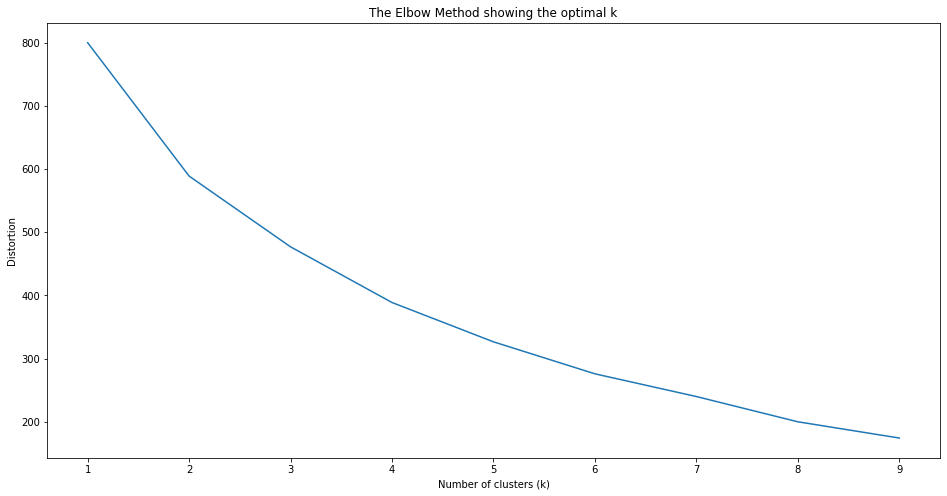

In [6]:
#Take customer ID out of features to be looked at
features = list(data_scaled.columns[1:])

#Instantise a list to record the distortions
distortions = []

#Set a range for cluster numbers
num_clusters = range(1,10)

#Loop over cluster range
for k in num_clusters:
    model = KMeans(n_clusters=k)
    model.fit(data_scaled[features])
    distortions.append(model.inertia_)
    
#Plot number of clusters against distortion
_ = plt.figure(figsize=(16,8))
_ = plt.plot(num_clusters, distortions)
_ = plt.xlabel('Number of clusters (k)')
_ = plt.ylabel('Distortion')
_ = plt.title('The Elbow Method showing the optimal k')
plt.show()

There is no obvious elbow point so let's look at a dendrogram.

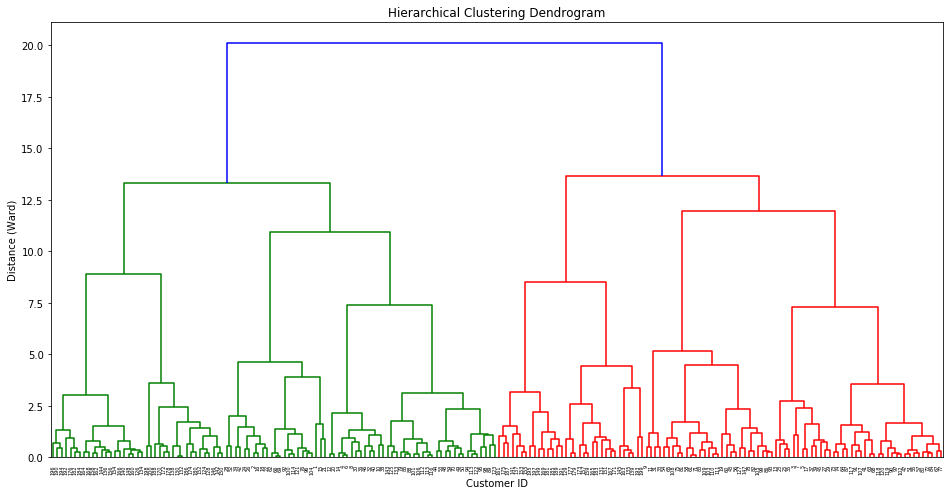

In [7]:
#First calculate the distance between each sample using `ward` method.
Z = linkage(data_scaled[features], 'ward')

#Plot dendogram
_ = plt.figure(figsize=(16,8))
_ = plt.title('Hierarchical Clustering Dendrogram')
_ = plt.xlabel('Customer ID')
_ = plt.ylabel('Distance (Ward)')
_ = dendrogram(Z, labels=(data.index + 1), leaf_rotation=90)
plt.show()

The clusters of the dendogram are more clearly defined compared to the elbow plot earlier which gave no obvious number to use for clusters.

Given the sample size of 200 I think 4 clusters is a reasonable number to form business insights on. This appears to equate to a distance of 12.5.

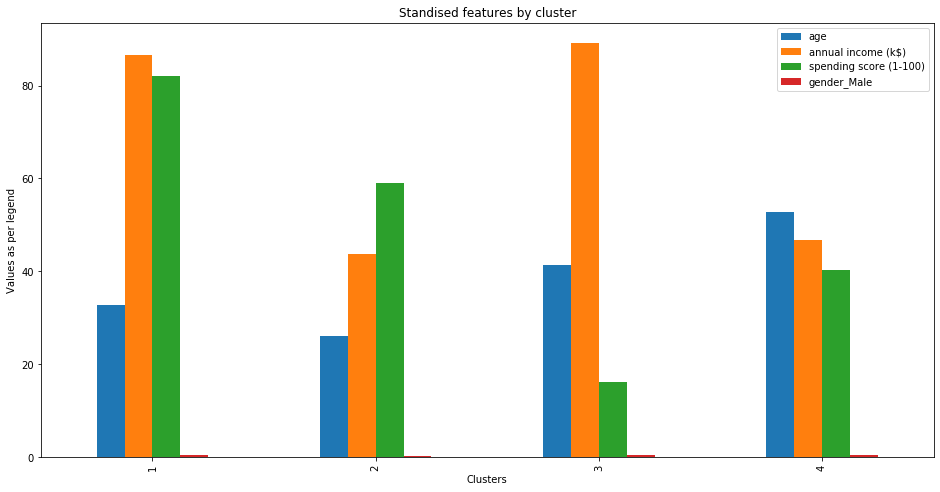

In [8]:
#Let's pull in the clusters at distance 12.5 and apply to the original data
data_dummies['clusters'] = fcluster(Z, 12.5, criterion='distance')

#Next let's look at the means of each feature at each cluster
_ = data_dummies.groupby(['clusters'])[features].mean().plot(kind='bar', figsize=(16,8), title='Standised features by cluster')
_.set_xlabel("Clusters")
_.set_ylabel("Values as per legend")
plt.show()

We now have the groups of clusters and their mean values for the 4 features:`age`, `annual income(k$)`, `spending score`, `gender`.

I did a separate chart (not shown) separating these groups further by `gender` and it has no influence on the shape of the graphs, so will not be considered in my analysis.

#### Cluster 1

This is a high earning, high spening group who seem to be around the age 30. I would suggest luxury items are marketed to this group as they like to spend, but also earn a good wage. This group may be on the cusp of starting families so enjoy indulging in luxury items and travel before settling down. Banking products such as mortgages may also be of interest as they move into that phase of their lives.

#### Cluster 2

These is a younger group who are probably early in their careers but still like to spend. They are likely to be more interested in spending money on socialising with friends so things like cinema, food, cafes, cheaper travel may be a good idea to market to them.

#### Cluster 3

This is the more middle aged group and the highest earning. Despite this their spending score is low. They are likely to have families and more cautious with spending as well as thinking about investing in the future. Given this products that promote family time such as cinema, or family deals as restaurants may be of interest. In addition investment products of any banks located in the mall could do well with this group.

#### Cluster 4

This is the older group who may be retired or middle aged lower income earners. Their spend is higher than cluster 3 suggesting they may be empty nesters and enjoy spending their money on family gifts, as well as going out for food and drinks. In addition, those who are retired may enjoy some travel options but probably less often than cluster 1.